In [81]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="finackdbgdb", password="coap")
  con.set_session(readonly=True, autocommit=False)

In [82]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

check_server_conf_1vclient_0attackers_newreala
check_server_conf_1vclient_1attackers_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,check_server_conf_1vclient_0attackers_newreala,1,5,1,originserver,pc2133,ubuntu1804-std
1,check_server_conf_1vclient_0attackers_newreala,1,6,4,proxy,microcloud,ubuntu1804-std
2,check_server_conf_1vclient_0attackers_newreala,1,2,5,client1,pc3060,ubuntu1804-std
3,check_server_conf_1vclient_1attackers_newreala,1,12,1,originserver,pc2133,ubuntu1804-std
4,check_server_conf_1vclient_1attackers_newreala,1,14,2,receiver,pc3060,ubuntu1804-std
5,check_server_conf_1vclient_1attackers_newreala,1,8,3,attacker,pc3060,ubuntu1804-std
6,check_server_conf_1vclient_1attackers_newreala,1,13,4,proxy,microcloud,ubuntu1804-std
7,check_server_conf_1vclient_1attackers_newreala,1,9,5,client1,pc3060,ubuntu1804-std


In [83]:
exp_id = "check_server_conf_1vclient_1attackers_newreala"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'attacker': 3, 'client1': 5, 'originserver': 1, 'proxy': 4, 'receiver': 2}
{'attacker': 8, 'client1': 9, 'originserver': 12, 'proxy': 13, 'receiver': 14}
{5}
{9}
4


In [84]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,attacker,1,163117,163117,1.638905e+09,1.638905e+09,19.700285
1,client1,1,381,769,1.638905e+09,1.638905e+09,94.577932
2,originserver,1,134414,269498,1.638905e+09,1.638905e+09,101.232159
3,proxy,1,163498,589025,1.638905e+09,1.638905e+09,101.402357
4,receiver,1,155587,155587,1.638905e+09,1.638905e+09,79.918585


In [85]:
client_messages_sql = f"""
SELECT
    e.observe_timestamp,
    e.message_marker,
    e.trial,
	m.src_id,
	m.dst_id,
    m.size_bytes
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["dst_id"].isin(client_node_ids), df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by=["trial", "message_marker"]).agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max"),
                                              src_id=("src_id", "max"),
                                              max_size_bytes=("size_bytes", "max")).reset_index()
rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3

rps_records = []

for t in rtts_df["trial"].unique():
    print(f"Trial {t}")
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        print(f"-- Client {client_number}")
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        client_trial_df["count"] = np.arange(1, len(client_trial_df) + 1)
        print(client_trial_df.describe())
        average_rps = client_trial_df["count"].max() / (client_trial_df["timestamp"].max() - client_trial_df["timestamp"].min())
        print(f"\naverage_rps={average_rps}")
        print()
        
        rps_records.append({
            "trial": t, 
            "src_id": src_id,
            "client_number": client_number,
            "average_rps": average_rps,
        })

# Add average rps per client per trial to the rtts df
rps_df = pd.DataFrame.from_records(rps_records)
rtts_df = rtts_df.merge(rps_df[["trial", "src_id", "average_rps"]], on=["trial", "src_id"], how="left")
        
rtts_df

Trial 1
-- Client 1
       trial  message_marker     rtt_sec     timestamp  src_id  \
count  378.0      378.000000  378.000000  3.780000e+02   378.0   
mean     1.0      197.904762    0.059008  1.638905e+09     5.0   
std      0.0      189.866144    0.063034  6.166703e+00     0.0   
min      1.0        1.000000    0.054177  1.638905e+09     5.0   
25%      1.0       95.250000    0.054513  1.638905e+09     5.0   
50%      1.0      189.500000    0.054682  1.638905e+09     5.0   
75%      1.0      283.750000    0.055010  1.638905e+09     5.0   
max      1.0     3165.000000    1.251116  1.638905e+09     5.0   

       max_size_bytes       rtt_ms       count  
count      378.000000   378.000000  378.000000  
mean       107.714286    59.008159  189.500000  
std          0.502363    63.033748  109.263443  
min        106.000000    54.176807    1.000000  
25%        107.000000    54.512501   95.250000  
50%        108.000000    54.682493  189.500000  
75%        108.000000    55.009842  283.75

,trial,message_marker,rtt_sec,timestamp,src_id,max_size_bytes,rtt_ms,average_rps
0,1,1,0.194585,1.638905e+09,5,106,194.585085,16.602426
1,1,2,0.057470,1.638905e+09,5,106,57.469845,16.602426
2,1,3,0.056150,1.638905e+09,5,106,56.149960,16.602426
3,1,4,0.056643,1.638905e+09,5,106,56.642771,16.602426
4,1,5,0.057012,1.638905e+09,5,106,57.011843,16.602426
...,...,...,...,...,...,...,...,...
373,1,374,0.054331,1.638905e+09,5,108,54.330826,16.602426
374,1,375,0.054192,1.638905e+09,5,108,54.191828,16.602426
375,1,376,0.060230,1.638905e+09,5,108,60.229778,16.602426
376,1,767,0.286540,1.638905e+09,5,108,286.540031,16.602426


In [101]:
client_df = rtts_df
client_df["rtt_ms"].describe()

count     378.000000
mean       59.008159
std        63.033748
min        54.176807
25%        54.512501
50%        54.682493
75%        55.009842
max      1251.116037
Name: rtt_ms, dtype: float64

<IPython.core.display.Javascript object>


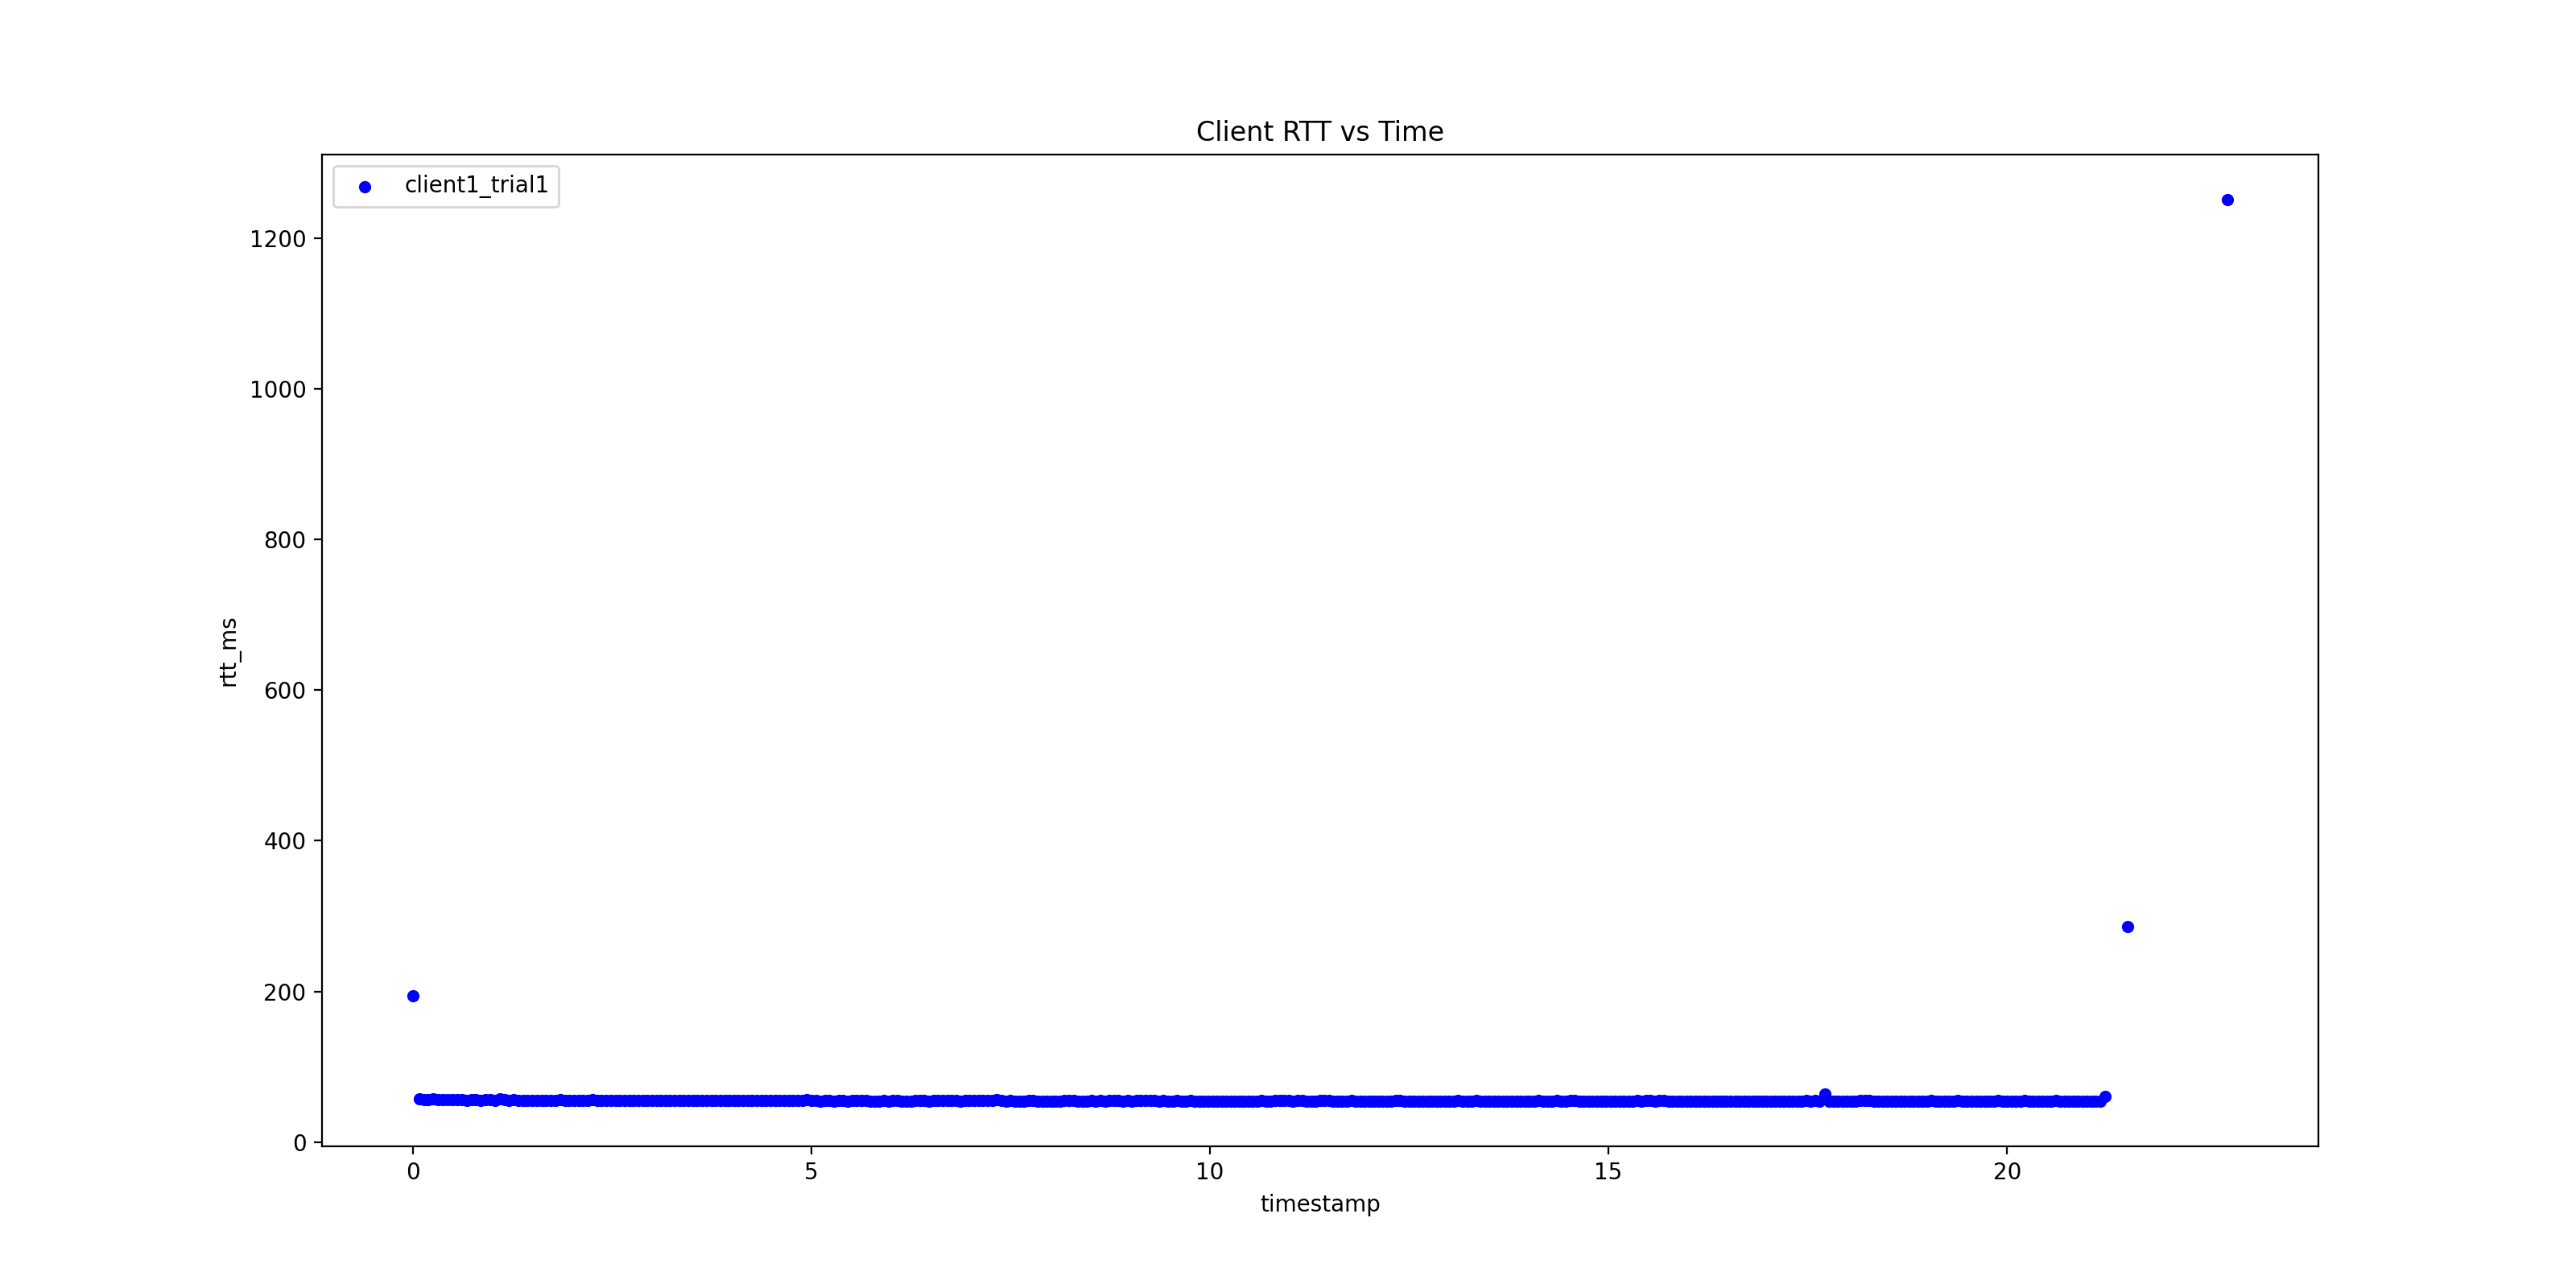

In [99]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {4,5}

ax = None
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        if ax:
            client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, ax=ax, color=color_map[(client_number, t)])
        else:
            ax = client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, color=color_map[(client_number, t)])

ax.set_title("Client RTT vs Time")            
plt.show()

<IPython.core.display.Javascript object>


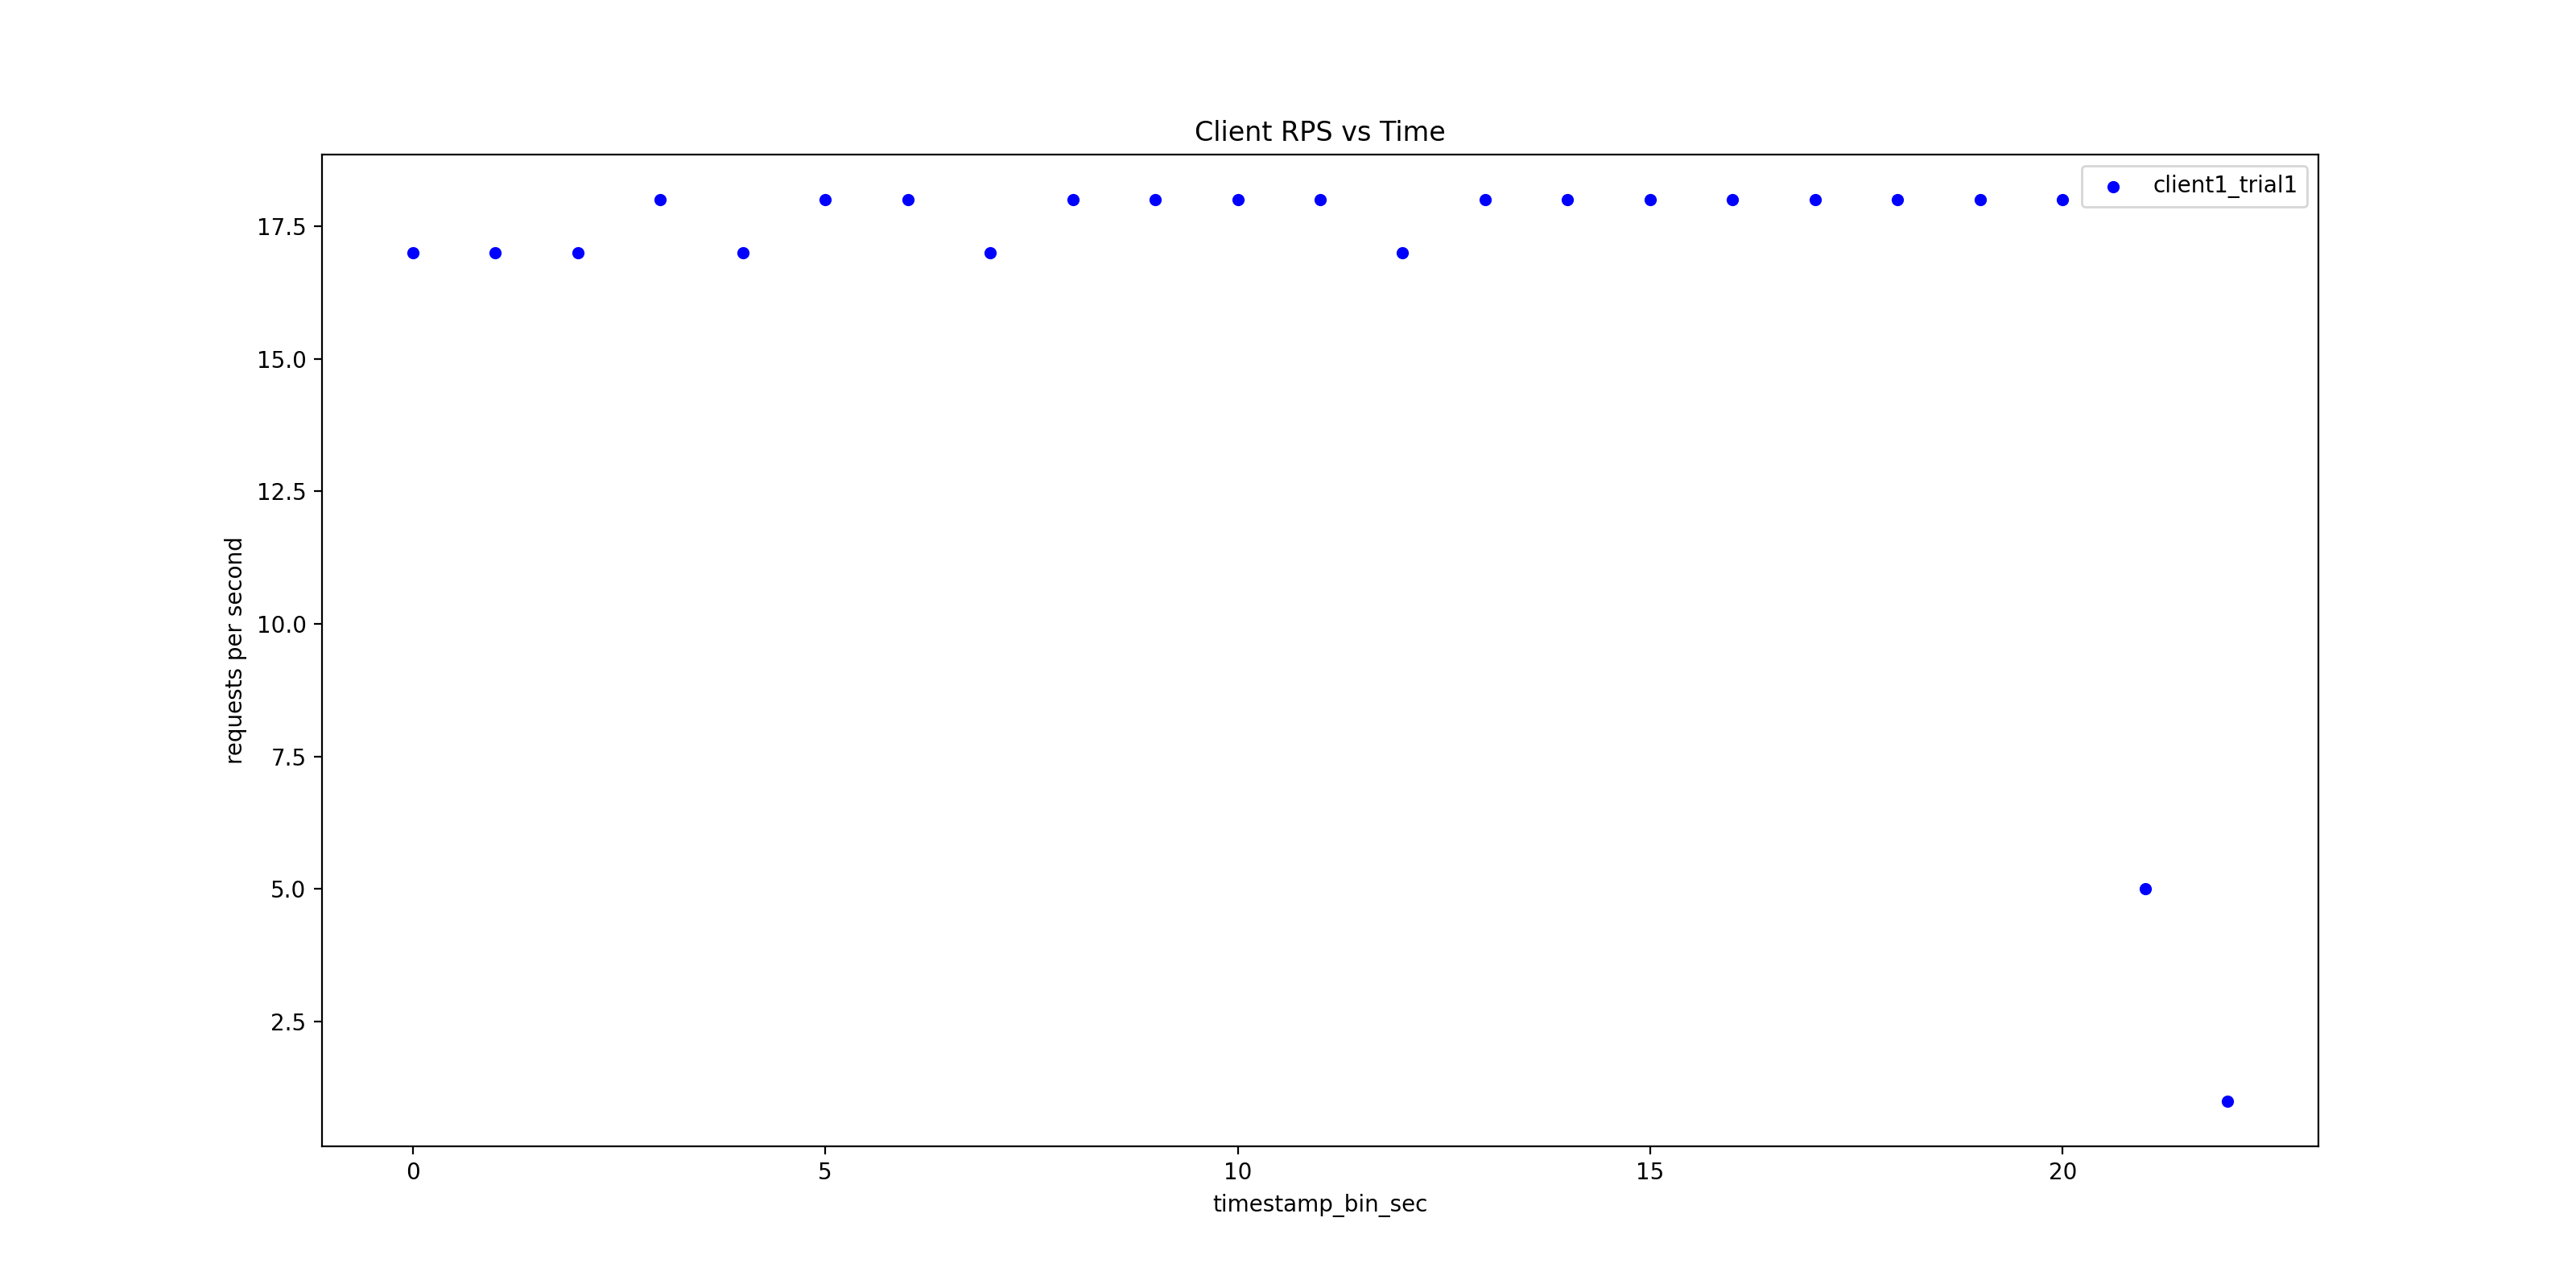

,timestamp_bin_sec,src_id,packets_per_second,bytes_per_second
0,0.0,5,17,1810
1,1.0,5,17,1819
2,2.0,5,17,1819
3,3.0,5,18,1926
4,4.0,5,17,1819
5,5.0,5,18,1931
6,6.0,5,18,1944
7,7.0,5,17,1836
8,8.0,5,18,1944
9,9.0,5,18,1944


In [100]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "src_id"]).agg(\
                                             packets_per_second=("max_size_bytes", "count"),
                                             bytes_per_second=("max_size_bytes", "sum")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="scatter", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_title("Client RPS vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


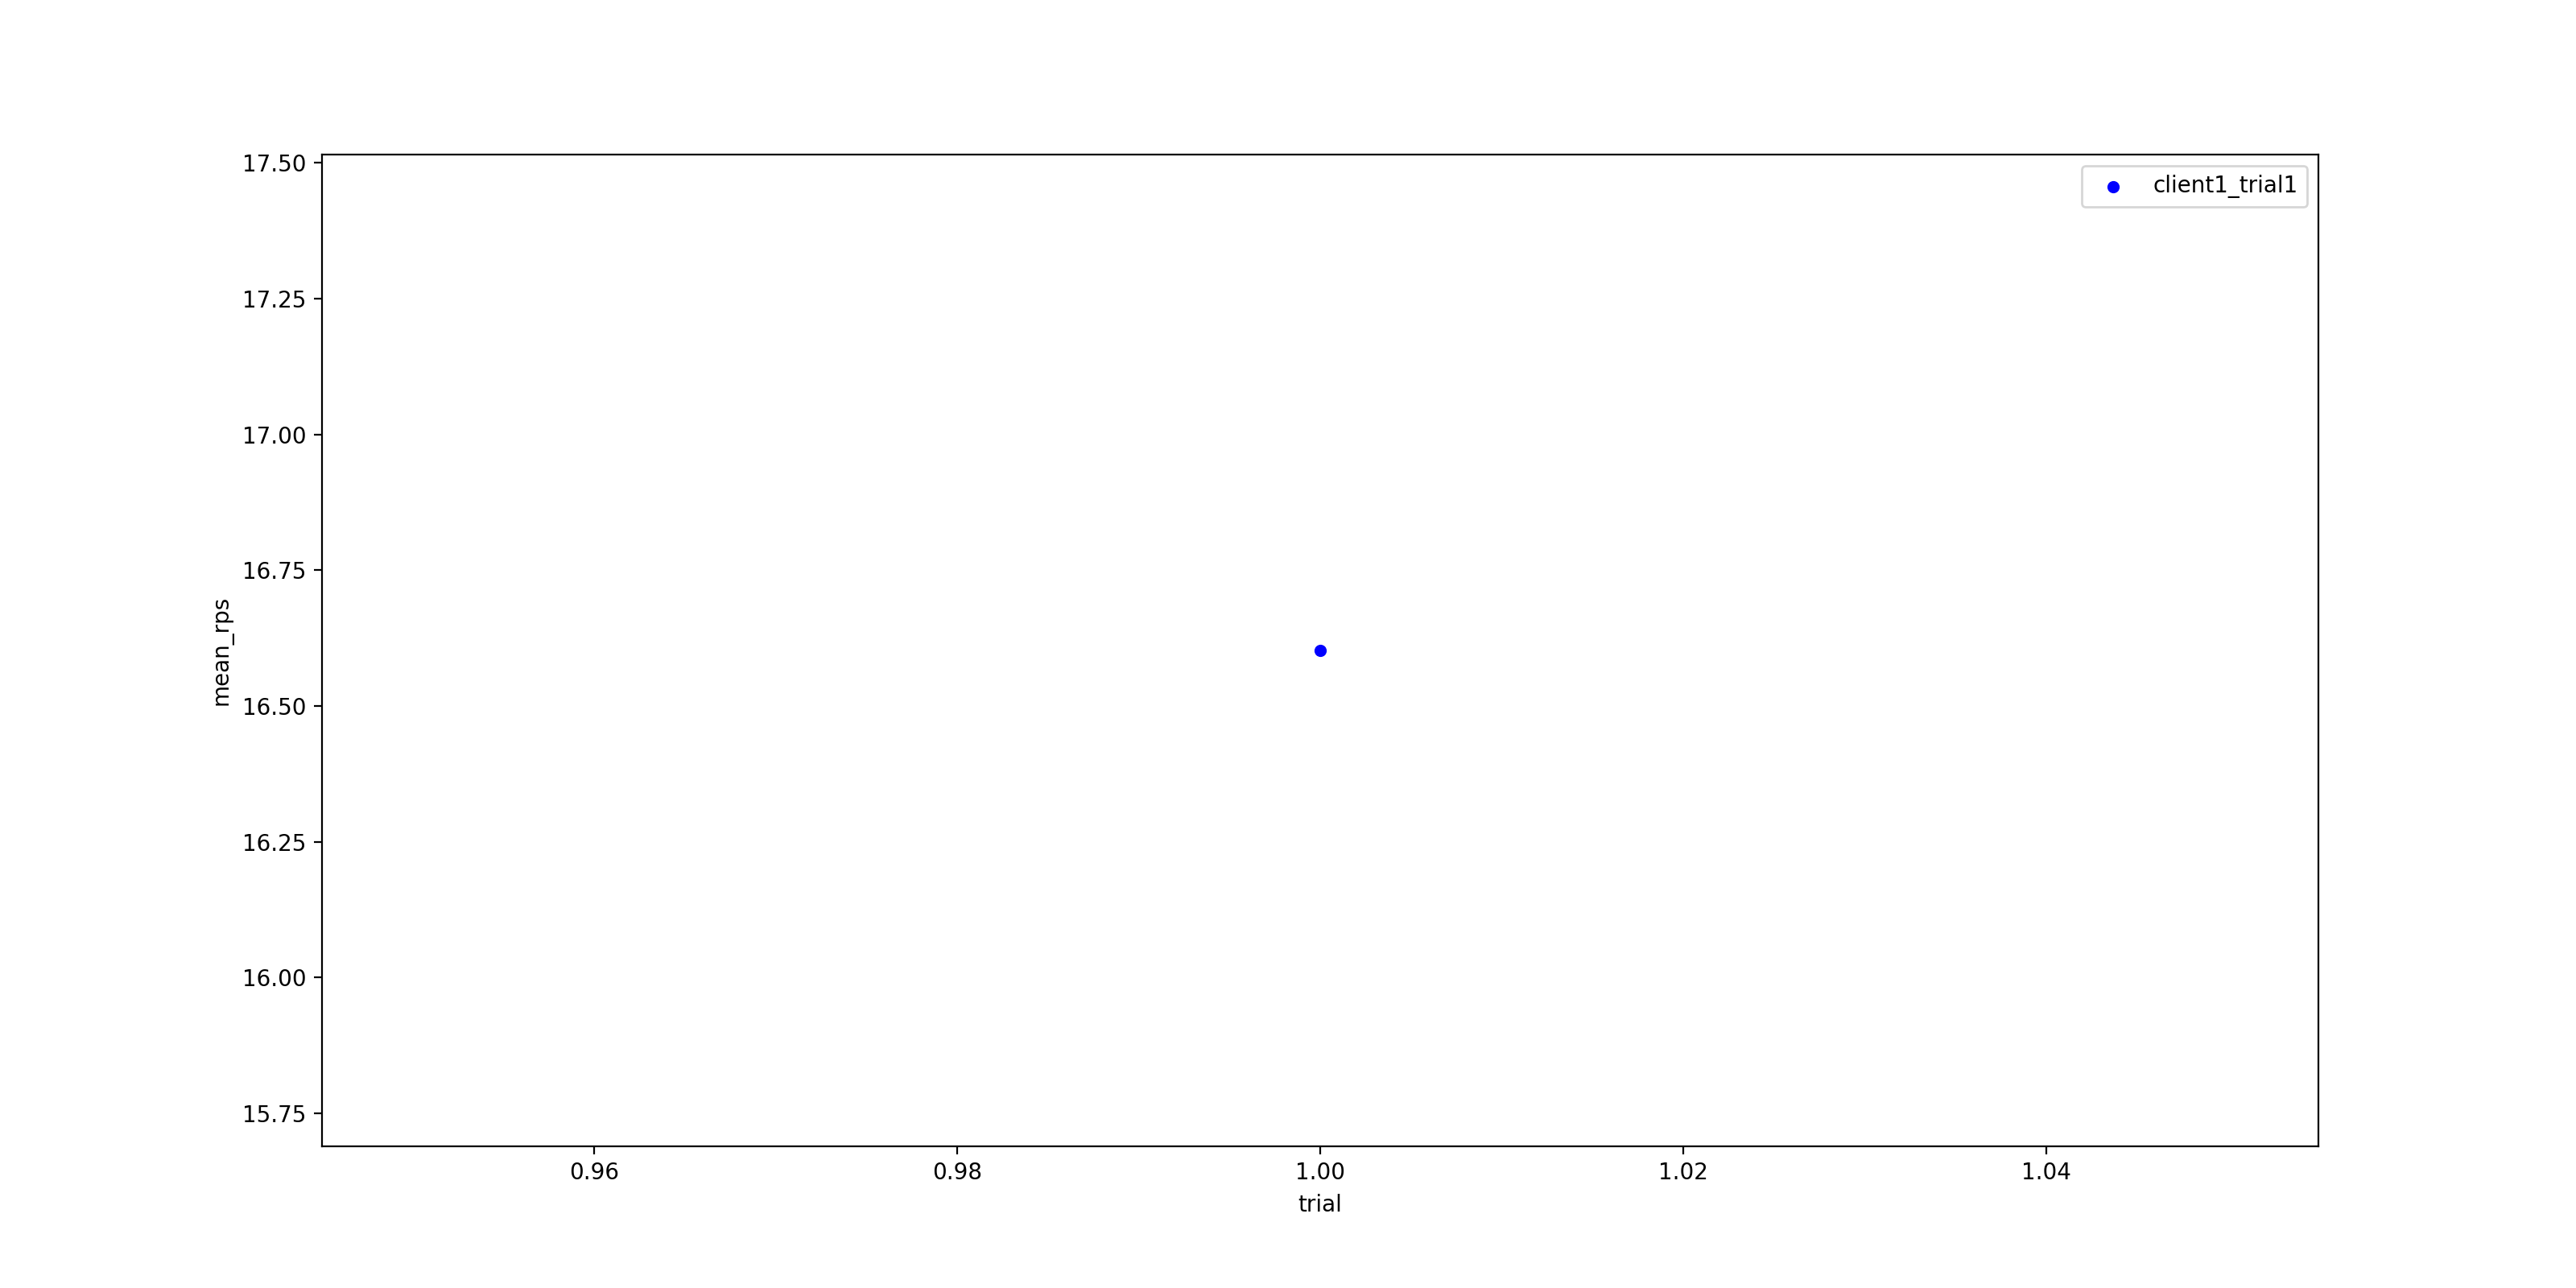

   trial   mean_rps
0      1  16.602426


,src_id,trial,mean_rps
0,5,1,16.602426


In [89]:
gdf = rtts_df.groupby(by=["src_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["src_id"].unique(), start=1):
        cdf = tdf[tdf["src_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
        
plt.show()

gdf

In [90]:
node_map_dnid

{'originserver': 12, 'receiver': 14, 'attacker': 8, 'proxy': 13, 'client1': 9}

In [91]:
# Dataframe of attacker message RTT from attacker to receiver

attacker_messages_sql = f"""
WITH negate_attacker_timestamp AS (
SELECT
    e.trial,
	e.message_marker,
	e.observer_id,
	CASE WHEN e.observer_id={node_map_dnid['attacker']} THEN -1 * e.observe_timestamp
		 ELSE e.observe_timestamp
	END AS timestamp
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
    JOIN node ndst ON ndst.node_id = m.dst_id
WHERE
	e.observer_id IN ({node_map_dnid['attacker']}, {node_map_dnid['receiver']})
)

SELECT 
	trial,
	message_marker,
	COUNT(timestamp) AS num_timestamps_should_be_2,
	MAX(timestamp) AS timestamp,
	SUM(timestamp) * 1e3 AS rtt_ms
FROM 
	negate_attacker_timestamp
GROUP BY
	trial,
	message_marker
"""

adf = pd.read_sql_query(attacker_messages_sql, con)
con.commit()
adf

adf["timestamp"] = abs(adf["timestamp"])
adf = adf[adf["rtt_ms"] > 0]
adf

,trial,message_marker,num_timestamps_should_be_2,timestamp,rtt_ms
0,1,4134,2,1.638905e+09,1681.061268
1,1,21740,2,1.638905e+09,9362.218857
2,1,4136,2,1.638905e+09,1680.571079
3,1,13490,2,1.638905e+09,5595.546007
4,1,6853,2,1.638905e+09,2716.619253
...,...,...,...,...,...
163112,1,161687,2,1.638905e+09,60032.483101
163113,1,159859,2,1.638905e+09,60062.561989
163114,1,153140,2,1.638905e+09,60046.216965
163115,1,149825,2,1.638905e+09,60042.596102


In [102]:
attacker_df = adf
attacker_df["rtt_ms"].describe()

count    155587.000000
mean      35104.789304
std       19318.771695
min         120.685101
25%       18200.135350
50%       36118.281126
75%       53891.760945
max       74495.800972
Name: rtt_ms, dtype: float64

<IPython.core.display.Javascript object>


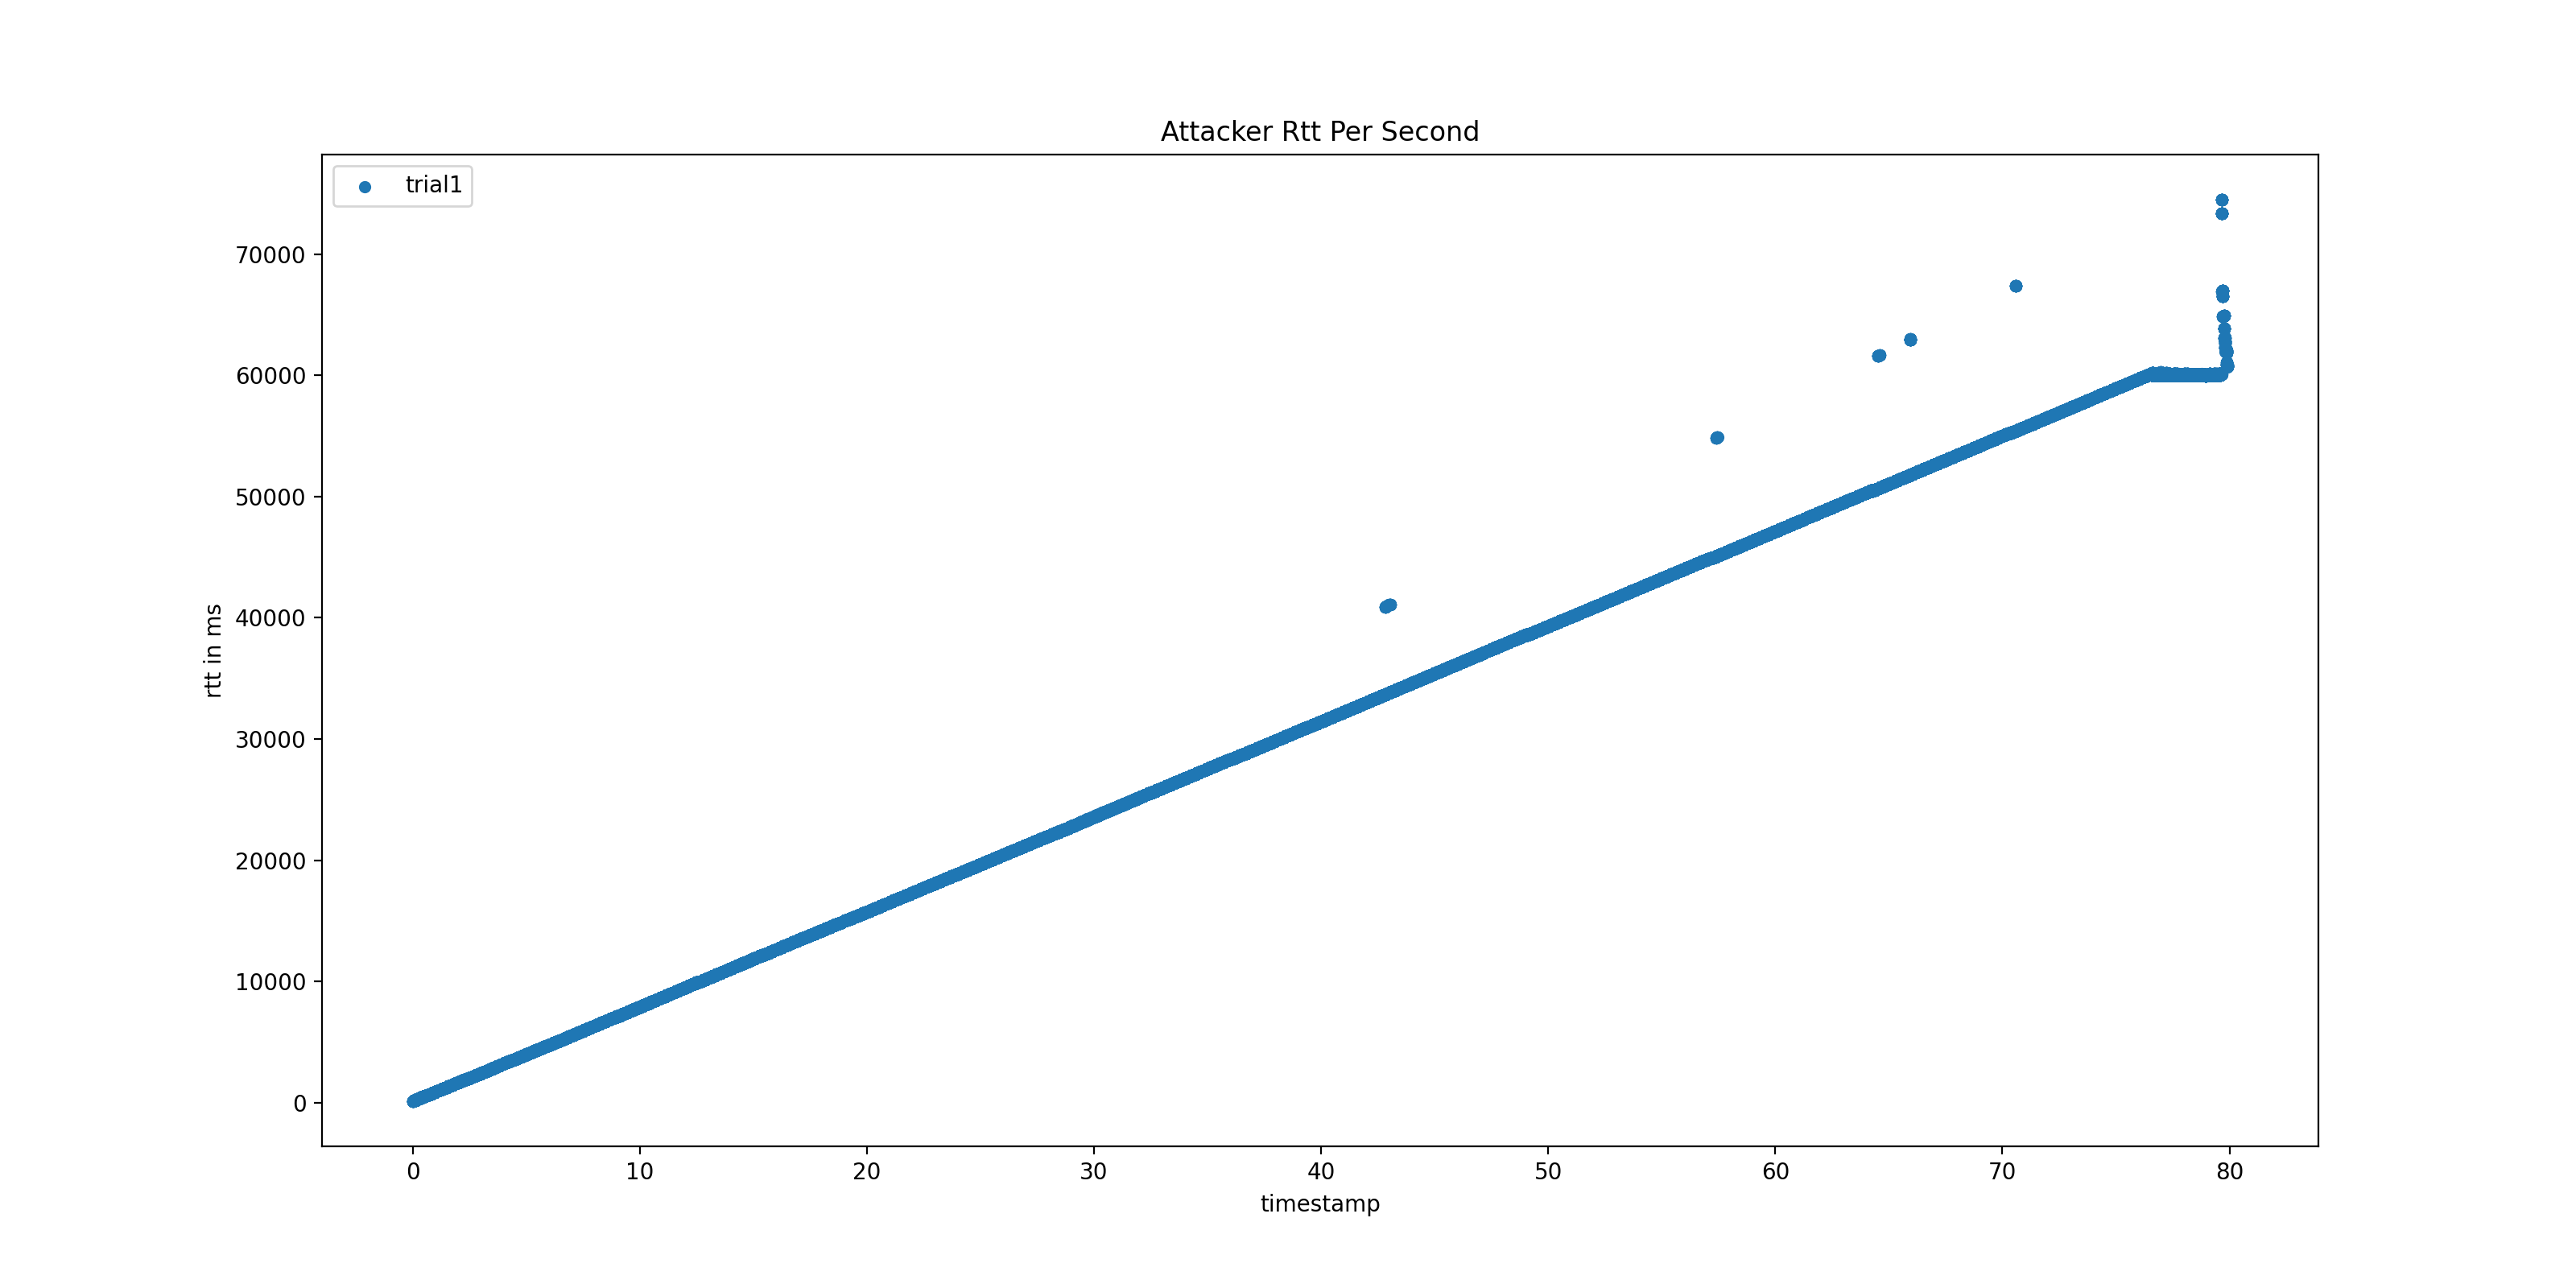

,trial,message_marker,num_timestamps_should_be_2,timestamp,rtt_ms
0,1,4134,2,1.999818,1681.061268
1,1,21740,2,11.814005,9362.218857
2,1,4136,2,1.999576,1680.571079
3,1,13490,2,7.061424,5595.546007
4,1,6853,2,3.361493,2716.619253
...,...,...,...,...,...
163112,1,161687,2,79.384170,60032.483101
163113,1,159859,2,79.194521,60062.561989
163114,1,153140,2,78.372321,60046.216965
163115,1,149825,2,77.967513,60042.596102


In [93]:
ax = None
for t in adf["trial"].unique():
    trial_df = adf[adf["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    label = f"trial{t}"
    ax = trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", ax=ax, label=label)
    
ax.set_ylabel("rtt in ms")
ax.set_title("Attacker Rtt Per Second")
plt.show()

trial_df

<IPython.core.display.Javascript object>


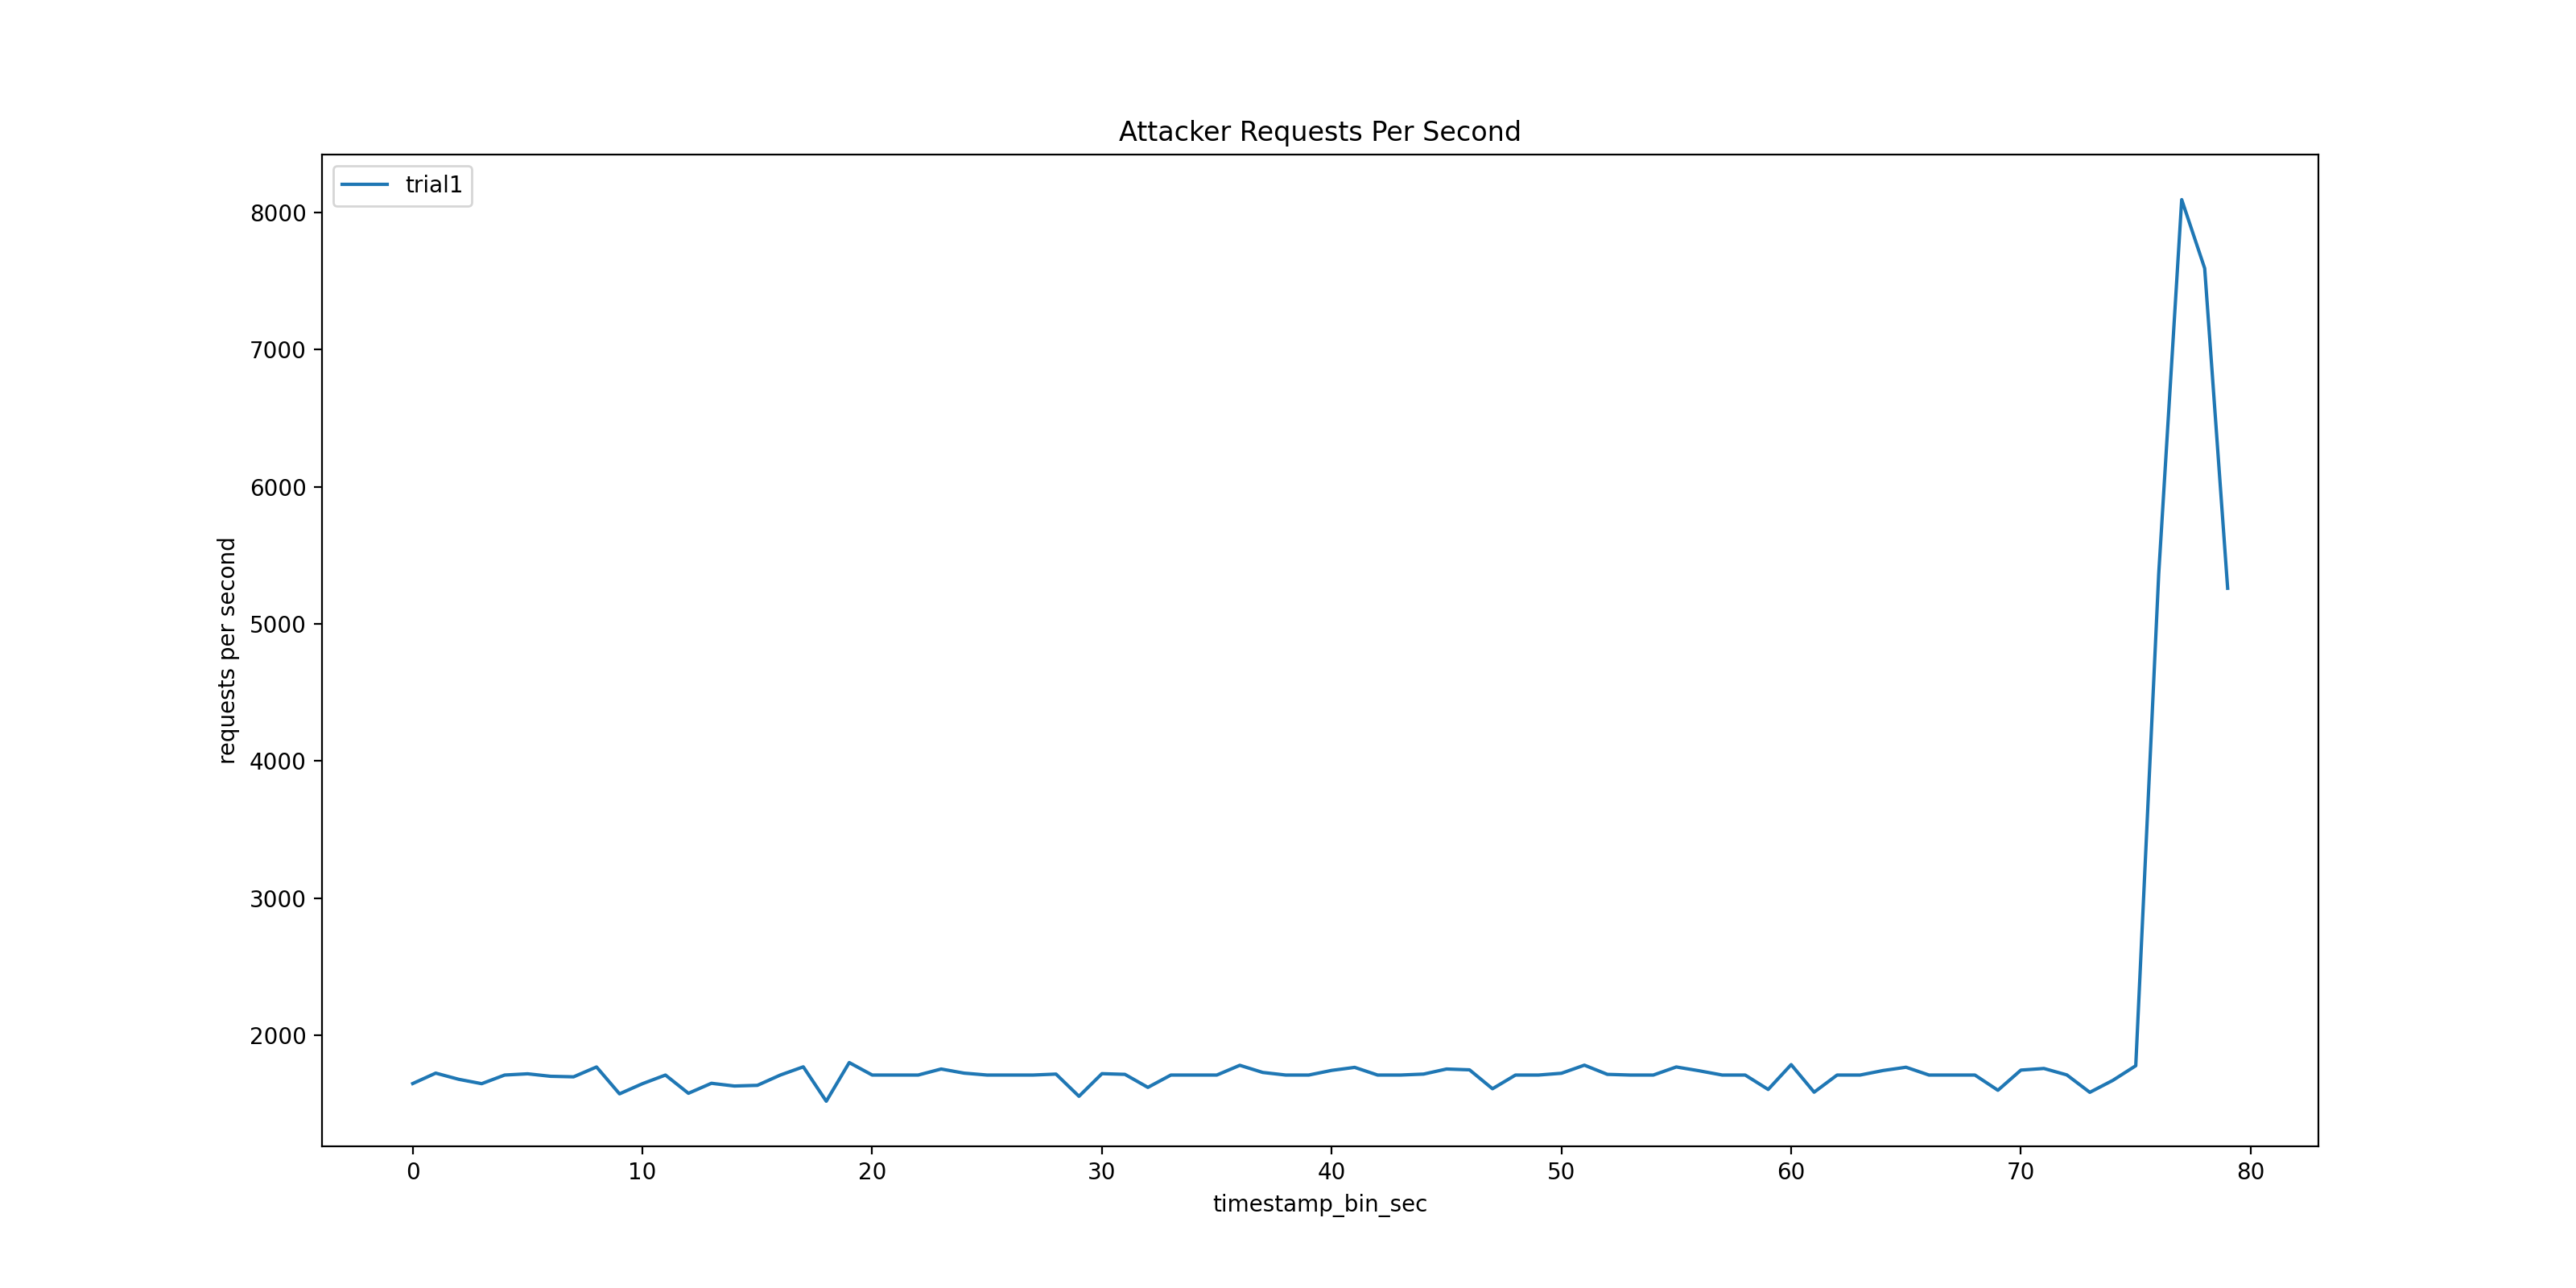

,timestamp_bin_sec,packets_per_second
0,0.0,1648
1,1.0,1724
2,2.0,1679
3,3.0,1647
4,4.0,1710
...,...,...
75,75.0,1778
76,76.0,5367
77,77.0,8094
78,78.0,7593


In [94]:
ax = None
for t in adf["trial"].unique():
    trial_df = adf[adf["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec"]).agg(\
                                         packets_per_second=("message_marker", "count")).reset_index()

    
    label = f"trial{t}"
    ax = time_stats_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, label=label)
    
ax.set_ylabel("requests per second")
ax.set_title("Attacker Requests Per Second")
plt.show()

time_stats_df

In [95]:
rtts_df

,trial,message_marker,rtt_sec,timestamp,src_id,max_size_bytes,rtt_ms,average_rps
0,1,1,0.194585,1.638905e+09,5,106,194.585085,16.602426
1,1,2,0.057470,1.638905e+09,5,106,57.469845,16.602426
2,1,3,0.056150,1.638905e+09,5,106,56.149960,16.602426
3,1,4,0.056643,1.638905e+09,5,106,56.642771,16.602426
4,1,5,0.057012,1.638905e+09,5,106,57.011843,16.602426
...,...,...,...,...,...,...,...,...
373,1,374,0.054331,1.638905e+09,5,108,54.330826,16.602426
374,1,375,0.054192,1.638905e+09,5,108,54.191828,16.602426
375,1,376,0.060230,1.638905e+09,5,108,60.229778,16.602426
376,1,767,0.286540,1.638905e+09,5,108,286.540031,16.602426


In [110]:
detailed_attacker_sql = f"""
SELECT
    e.trial,
	e.message_marker,
	n.node_name AS observer,
	nsrc.node_name AS src,
	ndst.node_name AS dst,
	e.observe_timestamp,
	cm.coap_type,
	cm.coap_code,
	cm.coap_retransmitted
FROM
	event e
	JOIN deployed_node d ON d.dnid = e.observer_id
		JOIN node n ON n.node_id = d.node_id
	JOIN message m ON e.message_id = m.message_id
    	JOIN node nsrc ON nsrc.node_id = m.src_id
		JOIN node ndst ON ndst.node_id = m.dst_id
		JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
	e.observer_id IN ({node_map_dnid['attacker']}, {node_map_dnid['receiver']}, {node_map_dnid['proxy']}, {node_map_dnid['originserver']})
"""
                                 
detailed_attacker_df = pd.read_sql_query(detailed_attacker_sql, con)
con.commit()

detailed_attacker_df.drop(detailed_attacker_df[detailed_attacker_df["src"].str.startswith("client")])
detailed_attacker_df

KeyError: "['trial' 'message_marker' 'observer' 'src' 'dst' 'observe_timestamp'\n 'coap_type' 'coap_code' 'coap_retransmitted'] not found in axis"

In [106]:
dadf = detailed_attacker_df
dadf

,trial,message_marker,observer,src,dst,observe_timestamp,coap_type,coap_code,coap_retransmitted
382240,1,163498,proxy,client1,proxy,1.638905e+09,con,get,False
386831,1,163498,proxy,client1,proxy,1.638905e+09,con,get,True
396174,1,163498,proxy,client1,proxy,1.638905e+09,con,get,True
414632,1,163498,proxy,client1,proxy,1.638905e+09,con,get,True
451442,1,163498,proxy,client1,proxy,1.638905e+09,con,get,True
482190,1,163498,proxy,proxy,client1,1.638905e+09,ack,content,False
